In [1]:
import h5py    
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import interp1d
from IPython.display import clear_output
import multiprocessing as mp
## Make sure plots are create inline
%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
from RSE_style import *
# figsize(10,8)



/Users/RuiCheng/anaconda/envs/cs155/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import h5py as h5
l1 = h5.File('./data/CFIS_L1_NGDCS20170619t184335_cal_2018_v2.h5','r')
spectra_ = np.array(l1['camera/radiances'][:])
wlSize=2048
disp = np.asarray([-1.2553e-6,0.0201,735.4572])
ind = np.linspace(1,wlSize,wlSize)
wlGrid_ = np.polyval(disp,ind )
wlGrid = wlGrid_[(wlGrid_>747)&(wlGrid_<756)]
spectra_ = spectra_[:,(wlGrid_>747)&(wlGrid_<756),:]
l1.close()



In [3]:
# Read in tabulated pre-computed dataset.
sun = np.loadtxt('data/solar_merged_20160127_600_26316_100.out')
# interpolate to common grid in wavelength (not wavenumber), use 0.002nm sampling here
res = 0.002
# create wavelength grid in nm
wl = np.arange(500,1000,res)
# Solar transmission spectrum, resample to wavelength grid (from wavenumber):
f = interp1d(1.e7/sun[:,0], sun[:,1])
Tsun = f(wl)
co = 2.355
T_cfis = gaussian_filter1d(Tsun, 0.07/res/co)




In [4]:
f1 = h5py.File('./data/PS_SIF_map_easy.h5','r')    
f1_keys=list(f1.keys())
list(f1.keys())
SIF_shape_ = f1['SIF_shape'][:] # (437,)

wl_sif = f1['wlGrid'][:] # dwlGrid = 0.03 (437,)
f = interp1d(wl_sif,SIF_shape_)
SIF_shape = f(wlGrid)
f1.close()

In [1203]:
spectra = np.mean(spectra_[100,:,500:600],axis=-1)
print(spectra_.shape)

(256, 501, 1432)


In [1204]:
co = 2.355

class Setup:
    pass
mySetup = Setup()

mySetup.FWHM = 0.07
# wo = np.where((wl_solarSpectrum>743)&(wl_solarSpectrum<757))[0]
# mySetup.wl_so = wl

mySetup.wl_in = wl
mySetup.wl_out = wlGrid
mySetup.res = 0.01 # wlGrid[1:]-wlGrid[0:-1]




In [1205]:
# reference solar spectrum
# Lo = Tsun*s_base/np.pi # mW/M2/SR/UM
Tsun = T_cfis.copy()
Lo = Tsun/np.pi 

In [1206]:

def forward_model_shift(x,b,compK = False):
    poly_wl = x[0:3]
    poly = x[-4:-1]
    a = x[-1]
#     c1 = x[0]; p0 = x[1]; p1 = x[2]; p2 = x[3]; a = x[4]
    

    Lo_conv = gaussian_filter1d(Lo,b.FWHM/b.res/co)
    
    detPixels = len(b.wl_in)
    grid = np.arange(0,detPixels,1)-detPixels/2.
#     wl_shifted = grid+c1 # b.nu_out in the example 8
    wl_shifted = np.polyval(poly_wl,grid)
    
    finter1 = interp1d(grid, Lo_conv,kind='linear', fill_value=np.NaN,bounds_error=False)
    Lo_conv_shifted = finter1(wl_shifted)
    
    finter2 = interp1d(b.wl_in, Lo_conv_shifted,kind='linear', fill_value=np.NaN,bounds_error=False)
    Lo_1 = finter2(b.wl_out)# output Lo
    
    dwl = b.wl_out-np.mean(b.wl_out)
    F_ref_nosif = Lo_1*np.polyval(poly,dwl)
    F_forward = F_ref_nosif+a*SIF_shape

    if compK:
        K = np.zeros((len(b.wl_out),len(x)))
#         dx = [5e-6,5e-6,5e-6]
        dx = [1e-6,1e-6,1e-6]
        for i in range(3):
            poly_wl2 = poly_wl.copy()
            poly_wl2[i] = poly_wl[i]+dx[i]
#             c1_2 = c1 + dx
            Lo_2 = finter1(np.polyval(poly_wl2,grid))
            finter3 = interp1d(b.wl_in, Lo_2,kind='linear', fill_value=np.NaN,bounds_error=False)
            Lo_2 = finter3(b.wl_out)
            FF = Lo_2*np.polyval(poly,dwl)+a*SIF_shape

            K[:,i] = (FF-F_forward)/dx[i]# partial I partial c1
        K[:,-4] = Lo_1*dwl**2 # partial I partial p0
        
        K[:,-3] = Lo_1*dwl# partial I partial p1
        K[:,-2] = Lo_1# partial I partial p2
        K[:,-1] = SIF_shape# partial I partial a
    if compK:
        return F_forward,K
    else:
        return F_forward


def iterate_fit(x0,b,F,n_itr=500,thrs = 1e-3):
    chi2_r_old = 1e9
    DOF = len(F)-len(x0)
    invSe = noise_model(F)
    F0_guess,K = forward_model_shift(x0,b,compK=True)
    Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
    x = x0+ Gain.dot(F-F0_guess)
    F0,K = forward_model_shift(x,b,compK=True)
    chi2 = np.sum((F0-F0_guess)**2*np.diag(invSe))
    chi2_r = chi2/DOF
    
    chi2_r_itr =[];x_linear_itr=[];sif_1sigma_itr=[]
    for i in range(n_itr):
        
        
        #F0,K = forward_model_shift(x,b,compK=True)
        Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
        
        x_plus1 = x+ Gain.dot(F-F0)
        S_posterior = np.linalg.inv(K.T.dot(invSe).dot(K))
        sif_1sigma = np.sqrt(S_posterior[-1,-1])
        #F2 = forward_model_shift(x_plus1,b)
        F2,K_new = forward_model_shift(x_plus1,b,compK=True)
        chi2 = np.sum((F2-F)**2*np.diag(invSe))
        chi2_r = chi2/DOF
        chi2_r_itr.append(chi2_r)
        x_linear_itr.append(x_plus1)
        sif_1sigma_itr.append(sif_1sigma)
        if abs(chi2_r-chi2_r_old) < thrs:
            print('iteration %d' %i)
            break
        else:
            x = x_plus1.copy() 
            chi2_r_old = chi2_r.copy()
            F0 = F2.copy()
            K = K_new.copy()
            
        
    return x_linear_itr,sif_1sigma_itr,chi2_r_itr



def noise_model(F):
# '''This is the noise model for each point on the map'''
# '''F is the measured radiance, which is a function of wavelength'''
    
    invSe = np.zeros((len(F),len(F)))
    
    noise = np.sqrt(F)/40
    
    invSe=np.diag(1./(noise**2) )
    return invSe


def linear_fit(F):
    invSe = noise_model(F)
    Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
    x_linear = Gain.dot(F)
    S_posterior = np.linalg.inv(K.T.dot(invSe).dot(K))
    sif_1sigma = np.sqrt(S_posterior[-1,-1])
    chi2 = np.sum((np.dot(K,x_linear)-F)**2*np.diag(invSe))
    chi2_r = chi2/(len(F)-len(x_linear))
    return x_linear,sif_1sigma,chi2_r

In [1207]:
F_forward,K = forward_model_shift([0,1,40]+[0.132,0.38,233.1,0],mySetup,compK=True)

x_linear,sif_1sigma,chi2_r = linear_fit(spectra)


In [1208]:
x_linear

array([ 5.86835815e-07, -1.60661756e-03, -9.64100048e+00,  1.31541156e-01,
        9.03841602e-01,  2.16210260e+02,  5.57553518e+00])

In [1209]:
chi2_r

1.7466978424638493

Text(0.5,1,'linear retrievel one step')

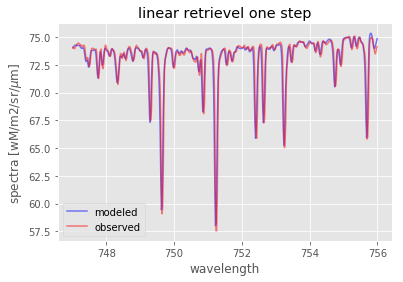

In [1210]:
plt.plot(mySetup.wl_out,F_forward,label='modeled',color='b',alpha=0.5)
plt.plot(mySetup.wl_out,spectra,label='observed',color='r',alpha=0.5)
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('linear retrievel one step')

In [1211]:
np.mean(wlGrid)

751.5550797906333

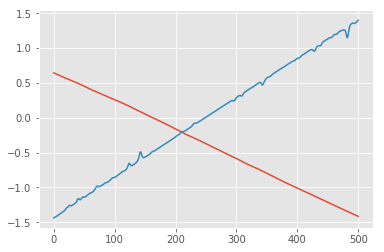

In [1212]:
plt.plot((K[:,6]-1)*7)
plt.plot(K[:,4])

Text(0.5,1,'F_forward-F_observed')

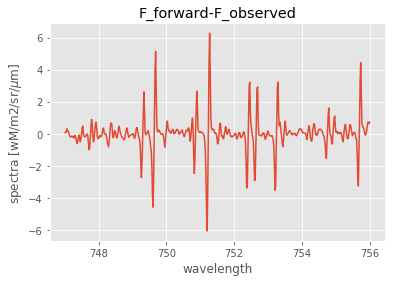

In [1213]:
plt.plot(mySetup.wl_out,F_forward-spectra)
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('F_forward-F_observed')

In [1214]:
ma,mb,mc = iterate_fit([0,1,40]+[0.132,0.38,233.1,0],mySetup,spectra,n_itr=200,thrs=1e-10)

iteration 14


In [1215]:
len(ma)

15

In [1216]:
np.array(ma)[:,-1]

array([-2.51831965, -2.72058525, -2.75389086, -2.77102186, -2.76937827,
       -2.76939933, -2.76942696, -2.76943372, -2.76943572, -2.76943629,
       -2.76943645, -2.7694365 , -2.76943651, -2.76943651, -2.76943652])

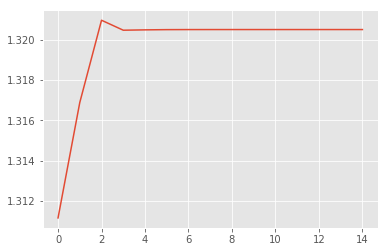

In [1217]:
plt.plot(mc)

In [1218]:
ma

[array([ 1.12424942e-07,  9.99226686e-01,  3.06330876e+01,  1.12416439e-01,
         4.54483273e-02,  2.40855243e+02, -2.51831965e+00]),
 array([ 1.59179941e-08,  9.99521304e-01,  3.05356604e+01,  1.11783671e-01,
         2.40916460e-02,  2.41471227e+02, -2.72058525e+00]),
 array([-1.44311352e-08,  9.99596088e-01,  3.05293022e+01,  1.11683100e-01,
         2.05974931e-02,  2.41572624e+02, -2.75389086e+00]),
 array([-1.11545060e-08,  9.99586089e-01,  3.05301848e+01,  1.11635339e-01,
         1.87570333e-02,  2.41624823e+02, -2.77102186e+00]),
 array([-1.12741683e-08,  9.99586558e-01,  3.05303801e+01,  1.11640035e-01,
         1.89328370e-02,  2.41619815e+02, -2.76937827e+00]),
 array([-1.13494863e-08,  9.99586734e-01,  3.05303629e+01,  1.11639975e-01,
         1.89307625e-02,  2.41619879e+02, -2.76939933e+00]),
 array([-1.13688831e-08,  9.99586784e-01,  3.05303568e+01,  1.11639890e-01,
         1.89278493e-02,  2.41619963e+02, -2.76942696e+00]),
 array([-1.13745554e-08,  9.99586799e-01,

In [1219]:
F_forward,K = forward_model_shift(np.array(ma)[-1,:],mySetup,compK=True)

Text(0.5,1,'non-linear retrievel last step')

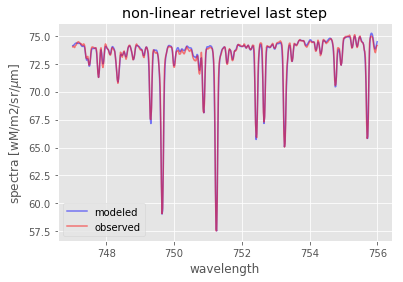

In [1220]:

plt.plot(mySetup.wl_out,F_forward,label='modeled',color='b',alpha=0.5)
plt.plot(mySetup.wl_out,spectra,label='observed',color='r',alpha=0.5)
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('non-linear retrievel last step')

Text(0.5,1,'F_forward-F_observed')

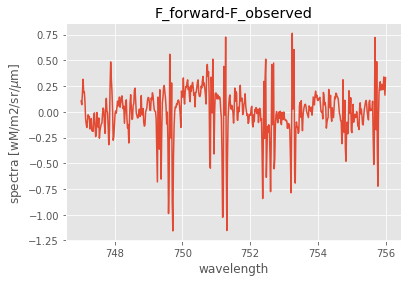

In [1221]:
plt.plot(mySetup.wl_out,F_forward-spectra)
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('F_forward-F_observed')

In [1222]:
spectra2 =spectra_[220,:,550]
F_forward,K = forward_model_shift([0,1,40]+[0.132,0.38,233.1,0],mySetup,compK=True)
x_linear,sif_1sigma,chi2_r = linear_fit(spectra2)


Text(0.5,1,'non-linear retrievel last step')

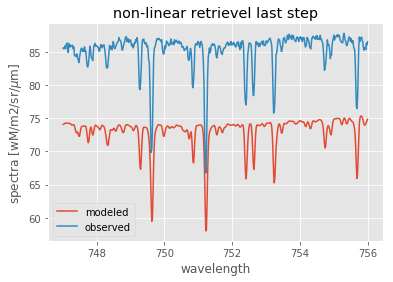

In [1223]:
plt.plot(mySetup.wl_out,F_forward,label='modeled')
plt.plot(mySetup.wl_out,spectra2,label='observed')
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('non-linear retrievel last step')

In [1224]:

ma,mb,mc =iterate_fit([0,1,40]+[0.132,0.38,233.1,0],mySetup,spectra2,n_itr=200,thrs=1e-10)

In [1225]:
F_forward,K = forward_model_shift(np.array(ma)[-1,:],mySetup,compK=True)

In [1226]:
ma

[array([-6.51803315e-08,  9.98936342e-01,  4.64763827e+01,  2.41324379e-02,
         1.99566041e-01,  2.77986884e+02, -1.67483593e+00]),
 array([-6.83696348e-08,  9.98939202e-01,  4.66174930e+01,  2.37107963e-02,
         1.79615828e-01,  2.78559195e+02, -1.86290896e+00]),
 array([-4.80817741e-08,  9.98882299e-01,  4.66154298e+01,  2.36908792e-02,
         1.78022680e-01,  2.78603306e+02, -1.87739083e+00]),
 array([-3.73892926e-08,  9.98850393e-01,  4.66284825e+01,  2.37087203e-02,
         1.78538076e-01,  2.78587213e+02, -1.87210223e+00]),
 array([-3.84411734e-08,  9.98856323e-01,  4.66222713e+01,  2.37166394e-02,
         1.79162260e-01,  2.78569426e+02, -1.86625369e+00]),
 array([-3.79073906e-08,  9.98853075e-01,  4.66261228e+01,  2.37170985e-02,
         1.79090359e-01,  2.78571379e+02, -1.86689692e+00]),
 array([-3.90397303e-08,  9.98858053e-01,  4.66217451e+01,  2.37164576e-02,
         1.79168015e-01,  2.78569312e+02, -1.86621661e+00]),
 array([-3.80666836e-08,  9.98853478e-01,

In [1227]:
np.array(ma)[:,-1]

array([-1.67483593, -1.86290896, -1.87739083, -1.87210223, -1.86625369,
       -1.86689692, -1.86621661, -1.86712373, -1.86627787, -1.86713962,
       -1.86628195, -1.86714069, -1.86628222, -1.86714076, -1.86628224,
       -1.86714076, -1.86628224, -1.86714076, -1.86628224, -1.86714076,
       -1.86628224, -1.86714076, -1.86628224, -1.86714076, -1.86628224,
       -1.86714076, -1.86628224, -1.86714076, -1.86628224, -1.86714076,
       -1.86628224, -1.86714076, -1.86628224, -1.86714076, -1.86628224,
       -1.86714076, -1.86628224, -1.86714076, -1.86628224, -1.86714076,
       -1.86628224, -1.86714076, -1.86628224, -1.86714076, -1.86628224,
       -1.86714076, -1.86628224, -1.86714076, -1.86628224, -1.86714076,
       -1.86628224, -1.86714076, -1.86628224, -1.86714076, -1.86628224,
       -1.86714076, -1.86628224, -1.86714076, -1.86628224, -1.86714076,
       -1.86628224, -1.86714076, -1.86628224, -1.86714076, -1.86628224,
       -1.86714076, -1.86628224, -1.86714076, -1.86628224, -1.86

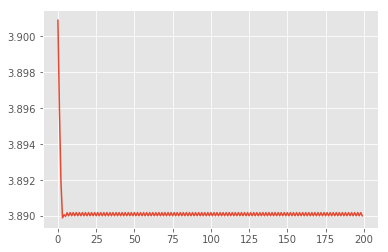

In [1228]:
plt.plot(mc)

Text(0.5,1,'spectra 2 non-linear retrievel last step')

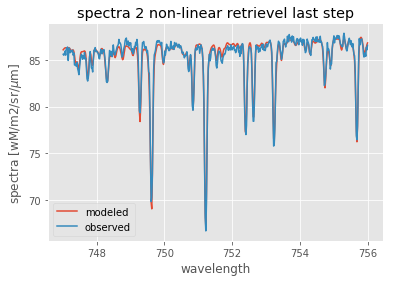

In [1229]:

plt.plot(mySetup.wl_out,F_forward,label='modeled')
plt.plot(mySetup.wl_out,spectra2,label='observed')
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('spectra 2 non-linear retrievel last step')

Text(0.5,1,'spectra 2 F_forward-F_observed')

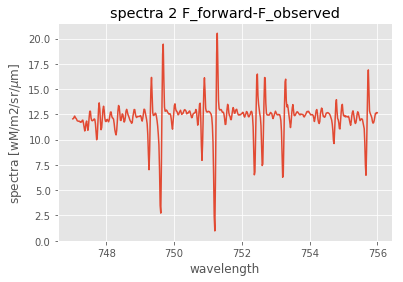

In [1230]:
plt.plot(mySetup.wl_out,F_forward-spectra)
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('spectra 2 F_forward-F_observed')

In [1231]:
np.array(ma)[:,-1]

array([-1.67483593, -1.86290896, -1.87739083, -1.87210223, -1.86625369,
       -1.86689692, -1.86621661, -1.86712373, -1.86627787, -1.86713962,
       -1.86628195, -1.86714069, -1.86628222, -1.86714076, -1.86628224,
       -1.86714076, -1.86628224, -1.86714076, -1.86628224, -1.86714076,
       -1.86628224, -1.86714076, -1.86628224, -1.86714076, -1.86628224,
       -1.86714076, -1.86628224, -1.86714076, -1.86628224, -1.86714076,
       -1.86628224, -1.86714076, -1.86628224, -1.86714076, -1.86628224,
       -1.86714076, -1.86628224, -1.86714076, -1.86628224, -1.86714076,
       -1.86628224, -1.86714076, -1.86628224, -1.86714076, -1.86628224,
       -1.86714076, -1.86628224, -1.86714076, -1.86628224, -1.86714076,
       -1.86628224, -1.86714076, -1.86628224, -1.86714076, -1.86628224,
       -1.86714076, -1.86628224, -1.86714076, -1.86628224, -1.86714076,
       -1.86628224, -1.86714076, -1.86628224, -1.86714076, -1.86628224,
       -1.86714076, -1.86628224, -1.86714076, -1.86628224, -1.86

In [1232]:
spectra_.shape

(256, 501, 1432)

In [1239]:

SIF = []; SIF_1SIGMA = [];CHI2_R = []
for i in range(100,102):
    for j in range(10,20):
        spectra = spectra_[i,:,j]
        ma,mb,mc =iterate_fit([0,1,40]+[0.132,0.38,233.1,0],mySetup,spectra,n_itr=200,thrs=1e-10)
        SIF.append(ma[-1][-1])
        SIF_1SIGMA.append(mb[-1])
        CHI2_R.append(mc[-1])
        

iteration 14
iteration 17
iteration 17
iteration 30
iteration 13
iteration 15
iteration 26
iteration 20
iteration 17
iteration 22
iteration 18
iteration 16
iteration 18
iteration 24
iteration 22


In [1241]:
SIF = np.reshape(np.array(SIF),(2,10))

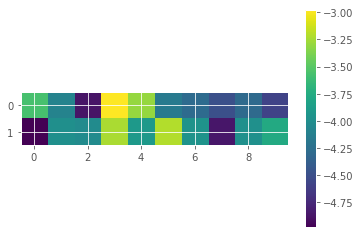

In [1244]:
plt.imshow(np.array(SIF))
plt.colorbar()

In [1245]:
SIF

array([[-3.56173738, -4.08393654, -4.87719827, -2.97753397, -3.2970219 ,
        -4.16211039, -4.28041544, -4.49176341, -4.28504129, -4.58051271],
       [-4.97995712, -3.98620439, -4.01655917, -3.23399441, -3.90082967,
        -3.20638275, -3.95050982, -4.85823439, -3.97430978, -3.76581071]])